Testing `pycroco` on the two stars described in [Giesers et al. (2019)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.475L..15G/abstract).

In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from spexxy.data import FitsSpectrum, Spectrum

sys.path.append(os.path.join(os.path.expanduser('~'), 'git', 'pycroco'))
from pycroco.crosscorrel import CrossCorrel
from pycroco.analysis import IterativeCC

Collect spectra of both stars from GCDB. This part only works on the MUSE servers. Alternatively, a tarball with the data can be downloaded [here](https://filestore.ljmu.ac.uk/invitations?share=aaf341f9e0fa223465fd&dl=0).

In [2]:
# import os
# import shutil
# import pandas as pd
# from datetime import datetime
# from astropy.time import Time
# from gcdb.tables import Extraction, SpectrumAnalysis, Star
# from gcdb.utils.config import Config

# input_folder = 'pycroco_input'
# if not os.path.exists(input_folder):
#     os.makedirs(input_folder)

# spectrum_properties = []

# for star_id in [1406607, 1406466]:
#     star = Star(star_id)

#     for spectrum in star.extracted_spectra(extraction_type=Extraction.Type.observed):
#         extraction = spectrum.extraction()
#         date_obs = Time(extraction.date_obs())
#         date_obs_string = datetime.strftime(extraction.date_obs(), '%Y%m%dT%H%M%S')

#         # get active params_isochrone analysis for tellurics spectrum
#         try:
#             params = extraction.analyses(type=SpectrumAnalysis.Type.params_isochrone, manual=0, active=1)[0]
#         except IndexError:
#             print(f'Missing params_isochrone analysis for {spectrum.filename()}.')
#         else:
#             shutil.copy(spectrum.filename(), input_folder)
#             tellurics_filename = os.path.join(input_folder, f'tellurics_{date_obs_string}.fits')
#             if not os.path.exists(tellurics_filename):
#                 shutil.copy(params.path('tellurics.fits'), tellurics_filename)
#             spectrum_properties.append(
#                 (spectrum.id, star_id, os.path.join(input_folder, spectrum['Filename']),
#                  tellurics_filename, spectrum['SNR'], date_obs.jd))

# out = pd.DataFrame(
#     spectrum_properties, columns=['id', 'Star_Id', 'Filename', 'Filename_tellurics', 'SNR', 'Julian-Date'])
# out.to_csv(os.path.join(input_folder, 'properties.csv'), index=False)

Load data and link spectra and tellurics

In [3]:
properties = pd.read_csv('pycroco_input/properties.csv', index_col='id')

tellurics_spectra = {}
julian_dates = []
for spectrum_id, row in properties.iterrows():
    jd = row['Julian-Date']
    fs = FitsSpectrum(os.path.join(row['Filename_tellurics']))
    tellurics_spectra[jd] = (fs.spectrum.wave, fs.spectrum.flux)

stars = properties.groupby('Star_Id')

Run iterative cross correlation

<IPython.core.display.Javascript object>


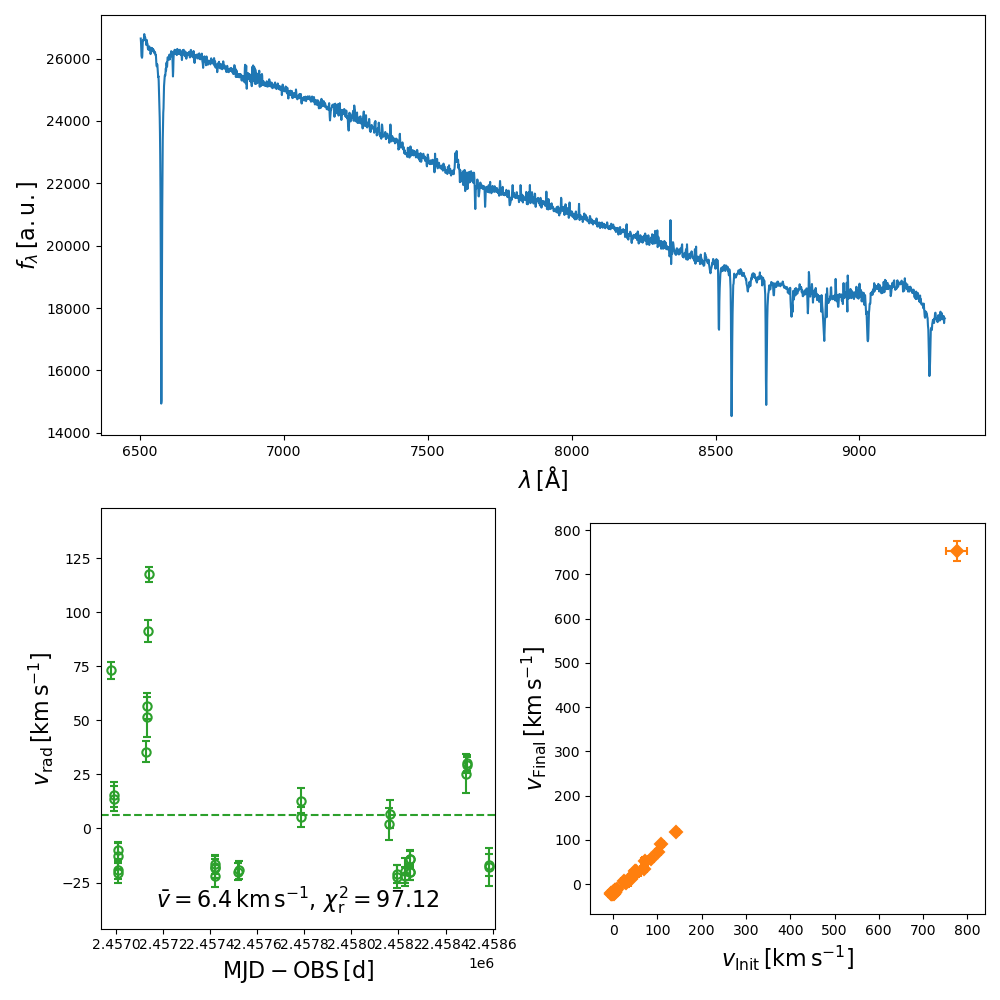

                   vrad   vrad_err      peak        fwhm       r_cc success  \
spectrum_id                                                                   
776919        91.204231   5.019378  0.595761  417.302178  30.176832    True   
778700       117.551175   3.566222  0.690482  409.667709   42.07791    True   
780387        56.547128   5.949936  0.560755  436.221548  26.493252    True   
782126       -10.074083   3.993125  0.715208  407.392826  37.258832    True   
785719        13.828091    5.69146   0.62859  434.994443  27.660997    True   
787341        73.043148    4.12112  0.637151  403.875149  35.750494    True   
824496        51.482443   9.187827  0.378028   458.63466  17.719115    True   
826105        35.522082   4.743585  0.583925  406.737177  31.154253    True   
832944        15.577609   5.681941   0.59873  395.499821  25.102422    True   
834716       -19.346096   4.234951  0.703687  399.285251  34.356244    True   
836739       -20.638064   4.741442  0.671579  412.49

In [9]:
star_id = 1406607 # 1406466 #
filename_template = None
wave_range = (6500., 9300.)
mask_ranges = None # [(5800., 6000.),]

fig = plt.figure(figsize=(10, 10))

cc = IterativeCC(spectra=stars.get_group(star_id), wave_range=wave_range, mask_ranges=mask_ranges, plot=True,
                 fig=fig, tellurics_spectra=tellurics_spectra, match_tellurics_by='Julian-Date', sort_by='SNR')
test_results = cc(max_iterations=20, dv_threshold=0.01, combine_threshold=0.4,
                  filtertype=CrossCorrel.Filter.Fourier, fit_width=300)
if filename_template is not None:
    cc.save_template(filename=filename_template, wave_mode=Spectrum.Mode.LOGLAMBDA, mask=True)
print(test_results)

Test cross correlation using final template and one of the input spectra

                             vrad  vrad_err     peak       fwhm       r_cc  \
template_id spectrum_id                                                      
9403995     780330       5.228589  3.398766  0.61151  305.51077  32.708273   

                        success        x0           var  
template_id spectrum_id                                  
9403995     780330         True  5.228589  16829.500528  


<IPython.core.display.Javascript object>


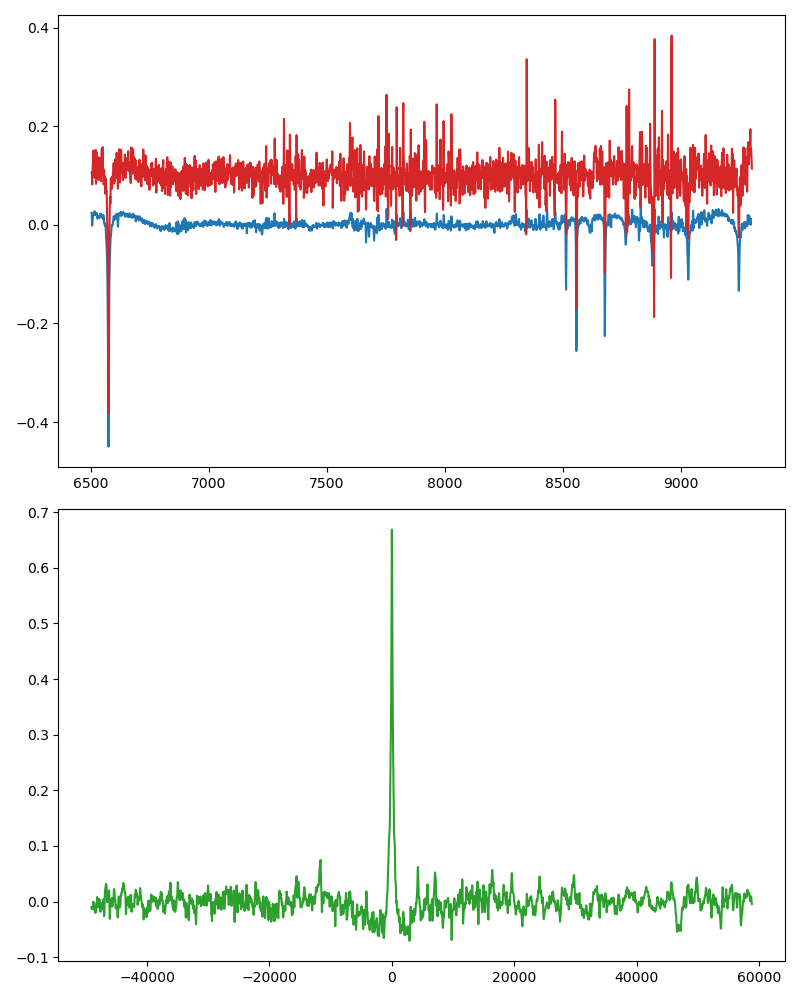

In [8]:
template_id = cc.template_id
spectrum_id = test_results.index[2]
template = cc.cc.templates[template_id].copy()
template.flux = cc.cc.templates[template_id].flux + 1.

spectrum = cc.cc.spectra[spectrum_id].copy(copy_flux=True)
spectrum.flux = cc.cc.spectra[spectrum_id].flux + 1.

cc_single = CrossCorrel()

cc_single.add(template, template=True, id=template_id, continuum_mode=CrossCorrel.ContinuumMode.Constant,
              continuum_kwargs={'c': 1})
cc_single.add(spectrum, template=False, id=spectrum_id, continuum_mode=CrossCorrel.ContinuumMode.Constant,
              continuum_kwargs={'c': 1})

r, signal, inputs = cc_single(filtertype=CrossCorrel.Filter.Fourier, full_output=True)
print(r)

pair = (template_id, spectrum_id)
vrad = r.loc[pair, 'vrad']

fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2,1)
ax = fig.add_subplot(gs[0])
ax.plot(10**inputs[pair][0].index, inputs[pair][0].values, ls='-', lw=1.5, c='C0', marker='None')
ax.plot(10**(inputs[pair][1].index-np.log10(1. + vrad / 299792.458)), inputs[pair][1].values + 0.1,
        ls='-', lw=1.5, c='C3', marker='None')

ax_cc = fig.add_subplot(gs[1])
vel = signal[pair].index
amp = signal[pair].values
ax_cc.plot(vel, amp, ls='-', lw=1.5, c='C2', marker='None')

fig.tight_layout()